## Problem 3

In [46]:
import numpy as np
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision.datasets import ImageNet
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image, ImageDraw

### resnet50 is selected as the pretrained classifier for this problem.

In [42]:
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### In the next two blocks, 10 classes in imagenette dataset are identified

In [9]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])        

In [43]:
with open('imagenet_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]

labelset = ImageFolder('labels/', transform=transform)
for i, (img, label) in enumerate(labelset):
    img = torch.unsqueeze(img, 0)
    out = resnet50(img)
    _, index = torch.max(out, 1)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    print(classes[index[0]])

    
    


0, tench
217, English_springer
482, cassette_player
491, chain_saw
497, church
566, French_horn
569, garbage_truck
571, gas_pump
574, golf_ball
701, parachute


### In the next four blocks the accuracy of resnet50 in classifying training set and validation set are measured

In [282]:
trainimg = ImageFolder('imagenette2-320/train/', transform=transform)
labels = np.asarray(trainimg.targets)

for i, l in enumerate([0, 217, 482, 491, 497, 566, 569, 571, 574, 701]):
    labels[labels == i] = l
    
pred = []

for i in range(len(trainimg)):
    out = resnet50(torch.unsqueeze(trainimg[i][0], 0))
    _, index = torch.max(out, 1)
    pred.append(index[0])


In [38]:
pred1 = np.array(pred)

print('Training set accuracy:', sum(pred1 == labels)/len(pred1))

Training set accuracy: 0.8545222929936306


In [36]:
valimg = ImageFolder('imagenette2-320/val/', transform=transform)
labels = np.asarray(valimg.targets)

for i, l in enumerate([0, 217, 482, 491, 497, 566, 569, 571, 574, 701]):
    labels[labels == i] = l
    
pred = []

for i in range(len(valimg)):
    out = resnet50(torch.unsqueeze(valimg[i][0], 0))
    _, index = torch.max(out, 1)
    pred.append(index[0])

In [37]:
pred2 = np.array(pred)

print('Validating set accuracy:', sum(pred2 == labels)/len(pred2))

Validating set accuracy: 0.8545222929936306


## Part a
### FGSM is applied to 1/5 of the validation set in the next five blocks

In [122]:
def fgsm_attack(image, epsilon, grad):
    sign = grad.sign()
    perturbed_image = image + epsilon*sign
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [315]:
def test( model, valimg, labels, epsilon ):
    correct = 0
    adv_examples = []
    
    for i in range(0, len(valimg), 5):
        x = torch.unsqueeze(valimg[i][0], 0)
        target = torch.tensor(labels[i]).to(torch.int64)
        target = target[None,]
        x.requires_grad = True
        out = model(x)
        pred1 = out.max(1, keepdim=True)[1]
        if pred1.item() != target.item():
            continue
        loss = F.nll_loss(out, target)
        model.zero_grad()
        loss.backward()
        x_grad = x.grad.data
        x2 = fgsm_attack(x, epsilon, x_grad)
        out = model(x2)
        pred2 = out.max(1, keepdim=True)[1]
        if pred2.item() == target.item():
            correct += 1
        else:
            if len(adv_examples) < 100:
                adv_ex = x2.squeeze().detach().cpu().numpy()
                adv_examples.append( (pred1.item(), pred2.item(), adv_ex, x_grad, epsilon) )
            
    final_acc = correct/float(len(range(0, len(valimg), 5)))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(range(0, len(valimg), 5)), final_acc))
    
    return final_acc, adv_examples

            

In [269]:
valimg = ImageFolder('imagenette2-320/val/', transform=transform)
labels = np.asarray(valimg.targets)

for i, l in enumerate([0, 217, 482, 491, 497, 566, 569, 571, 574, 701]):
    labels[labels == i] = l
    
epsilons = [.001, .005, .05, .25]
Accuracies = []

for epsilon in epsilons:
    acc, examples = test( resnet50, valimg=valimg, labels=labels, epsilon=epsilon )
    Accuracies.append(acc)


Epsilon: 0.001	Test Accuracy = 281 / 785 = 0.3579617834394904
Epsilon: 0.005	Test Accuracy = 265 / 785 = 0.3375796178343949
Epsilon: 0.05	Test Accuracy = 184 / 785 = 0.23439490445859873
Epsilon: 0.025	Test Accuracy = 44 / 785 = 0.05605095541401274


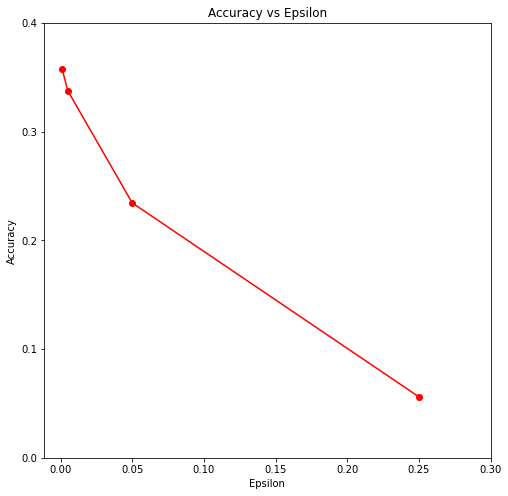

In [280]:
plt.figure(figsize=(8,8))
plt.plot(epsilons, Accuracies, "o-", color ='r')
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(1.1, 0.5, ' = ')

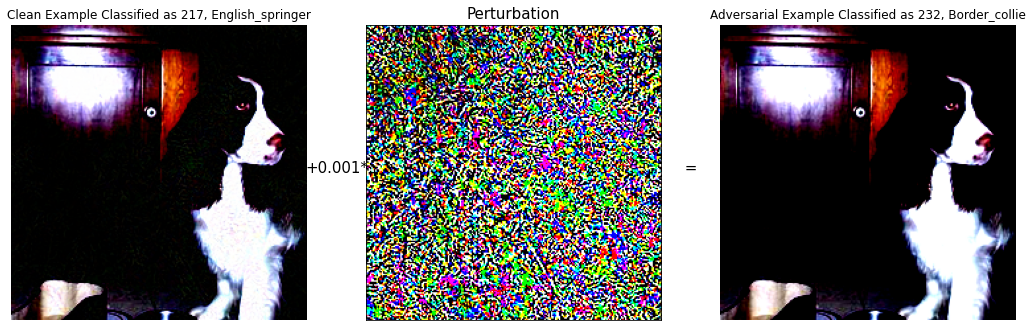

In [245]:
n=15
x = torch.tensor(examples[n][2]) - torch.squeeze(examples[n][3])
# x = x.mul(torch.FloatTensor([0.229, 0.224, 0.225]).view(3,1,1)).add(torch.FloatTensor([0.485, 0.456, 0.406]).view(3,1,1)).numpy()
x = np.moveaxis(x.numpy(), 0, -1)
x = np.clip(x, 0, 1)

x_adv = torch.tensor(examples[n][2])
# x_adv = x_adv.mul(torch.FloatTensor([0.229, 0.224, 0.225]).view(3,1,1)).add(torch.FloatTensor([0.485, 0.456, 0.406]).view(3,1,1)).numpy()
x_adv = np.moveaxis(x_adv.numpy(), 0, -1)
x_adv = np.clip(x_adv, 0, 1)

grad =torch.squeeze(examples[n][3]).numpy()*255
grad = np.moveaxis(grad, 0, -1)
grad = np.clip(grad, 0, 255)

figure, ax = plt.subplots(1,3, figsize=(18,8))
ax[0].imshow(x)
ax[0].set_title('Clean Example Classified as ' + classes[examples[n][0]], fontsize=12)
ax[0].axis('off')

ax[1].imshow(grad)
ax[1].set_title('Perturbation', fontsize=15)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(x_adv)
ax[2].set_title('Adversarial Example Classified as ' + classes[examples[n][1]], fontsize=12)
ax[2].axis('off')

ax[0].text(1.1,0.5, "+{}*".format(format(round(examples[0][4],3))), size=15, ha="center", transform=ax[0].transAxes)
ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)




## Part b
### Iterative gradient sign is applied to 1/5 of the validation set in the next four blocks

In [143]:
def itterative_fgsm(image, labels, model, epsilon, alpha, nSteps):
    x = torch.unsqueeze(image, 0)
    x.requires_grad = True
    out = model(x)
    pred = out.max(1, keepdim=True)[1]
    for i in range(nSteps):
        model.zero_grad()
        out = model(x)
        pred1 = out.max(1, keepdim=True)[1]
        target = torch.tensor(labels[i]).to(torch.int64)
        target = target[None,]
        loss = F.nll_loss(out, target)
        loss.backward()
        x_grad = alpha * torch.sign(x.grad.data)
        x2_temp = x.data + x_grad
        total_grad = x2_temp - torch.unsqueeze(image, 0)
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)
        x2 = torch.unsqueeze(image, 0) + total_grad
        x = x2
        x.requires_grad = True
    out = model(x2)
    pred2 = out.max(1, keepdim=True)[1]
    return pred, pred2, x, total_grad
    

In [283]:
valimg = ImageFolder('imagenette2-320/val/', transform=transform)
labels = np.asarray(valimg.targets)

epsilons = [.001, .005, .05, .25]
Accuracies = []

for epsilon in epsilons:

    wrong=0
    examples = []

    for i in range(0, len(valimg), 5):
        pred, pred2, adv_x, total_grad = itterative_fgsm(image=valimg[i][0], labels=labels, model=resnet50 , epsilon = epsilon, alpha=0.025, nSteps=5)

        if pred != pred2:
            wrong += 1
            adv_x = adv_x.squeeze().detach().cpu().numpy()
            examples.append( (pred.item(), pred2.item(), adv_x, total_grad) )
    acc = (len(range(0, len(valimg), 5)) - wrong)/len(range(0, len(valimg)))
    Accuracies.append(acc)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, (len(range(0, len(valimg), 5)) - wrong), len(range(0, len(valimg), 5)), acc))
    

Epsilon: 0.001	Test Accuracy = 771 / 785 = 0.1964331210191083
Epsilon: 0.005	Test Accuracy = 725 / 785 = 0.18471337579617833
Epsilon: 0.05	Test Accuracy = 415 / 785 = 0.10573248407643313
Epsilon: 0.25	Test Accuracy = 297 / 785 = 0.0756687898089172


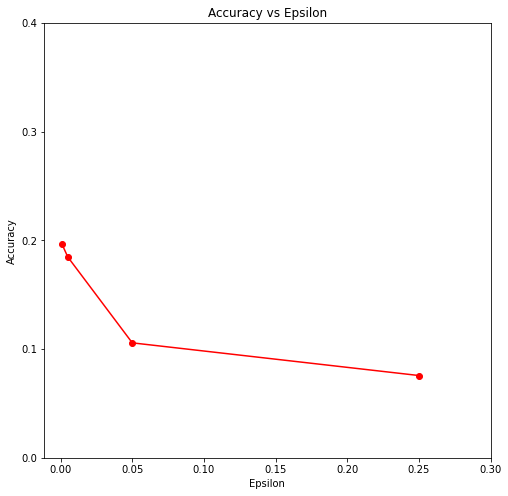

In [317]:
plt.figure(figsize=(8,8))
plt.plot(epsilons, Accuracies, "o-", color ='r')
plt.yticks(np.arange(0, 0.5, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(1.1, 0.5, ' = ')

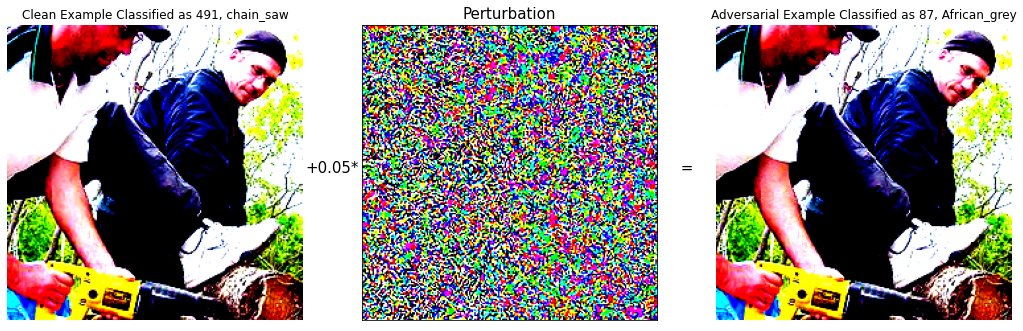

In [264]:
n=26
x = torch.tensor(examples[n][2]) - torch.squeeze(examples[n][3])
# x = x.mul(torch.FloatTensor([0.229, 0.224, 0.225]).view(3,1,1)).add(torch.FloatTensor([0.485, 0.456, 0.406]).view(3,1,1)).numpy()
x = np.moveaxis(x.numpy(), 0, -1)
x = np.clip(x, 0, 1)

x_adv = torch.tensor(examples[n][2])
# x_adv = x_adv.mul(torch.FloatTensor([0.229, 0.224, 0.225]).view(3,1,1)).add(torch.FloatTensor([0.485, 0.456, 0.406]).view(3,1,1)).numpy()
x_adv = np.moveaxis(x_adv.numpy(), 0, -1)
x_adv = np.clip(x_adv, 0, 1)

grad =torch.squeeze(examples[n][3]).numpy()*255
grad = np.moveaxis(grad, 0, -1)
grad = np.clip(grad, 0, 255)

figure, ax = plt.subplots(1,3, figsize=(18,8))
ax[0].imshow(x)
ax[0].set_title('Clean Example Classified as ' + classes[examples[n][0]], fontsize=12)
ax[0].axis('off')

ax[1].imshow(grad)
ax[1].set_title('Perturbation', fontsize=15)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(x_adv)
ax[2].set_title('Adversarial Example Classified as ' + classes[examples[n][1]], fontsize=12)
ax[2].axis('off')

ax[0].text(1.1,0.5, "+{}*".format(0.05), size=15, ha="center", transform=ax[0].transAxes)
ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)




## Part c
### Feature denoising defense mechanism is applied in the next bloxk based on Guo et al. (2018) ICLR paper

In [316]:
_, examples = test( resnet50, valimg=valimg, labels=labels, epsilon=0.25 )

correct = 0

for i in range(len(examples)):

    x = examples[i][2]
    x = torch.tensor(x)
    x = torch.unsqueeze(x, 0)

    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        ])

    x = transform(x)

    x = transform(x)
    x = x - torch.min(x)
    x = x / torch.max(x)
    x = x*8

    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        ])

    out = resnet50(x)
    pred3 = out.max(1, keepdim=True)[1]
    if pred3.item() == examples[i][0]:
        correct += 1
print(correct)

Epsilon: 0.25	Test Accuracy = 4 / 785 = 0.005095541401273885
0
